# **Preprocess the dataset and stores tensors to Google Driver**

## Instructions for Accessing and Running the Code

To ensure smooth execution of the code, please follow the steps below carefully:

### Step 1: Accessing the Public Folders
While our image folders are shared publicly on Google Drive, you still need to create a shortcut for them in your drive to access them smoothly. Follow the instructions below to do so:

1. **Requesting Access**:
    - The folders, while public, might still require explicit access. If so, please request access by sending an email to [bilal2.rabbi@live.uwe.ac.uk](mailto:bilal2.rabbi@live.uwe.ac.uk).

2. **Creating a Shortcut**:
    - Navigate to the shared folder on Google Drive.
    - Right-click on the desired folder.
    - From the context menu, hover over `Organize` to reveal further options.
    - Click on `Add Shortcut to My Drive`.
    - Choose the location in `My Drive`  and confirm.

### Step 2: Running the Code

Once you've successfully added the shortcut to your drive, you can proceed to run the provided code. Ensure the code references the correct paths, matching where you've added the shortcuts in your Google Drive.

---

By following the above instructions carefully, you should face no issues accessing the images and running the code. If you encounter any issues, please reach out for further assistance.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import os
path = os.path.join('/content/drive/MyDrive/')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


##**Read data files** ##

Read dataframes from csv files

In [ ]:
!pip install requests

In [ ]:
import pandas as pd
import os
import requests
from io import StringIO

path = '/content/drive/MyDrive'
# train_file = os.path.join(path, 'combined_train.csv')
# val_file = os.path.join(path, 'combined_val.csv')
# test_file = os.path.join(path, 'combined_test.csv')

# train_df = pd.read_csv(train_file)
# val_df = pd.read_csv(val_file)
# test_df = pd.read_csv(test_file)



url = "https://drive.google.com/uc?id=1eyUZPqxU1H-heqZHFhQ74hqp5rlBLWsA"
response = requests.get(url)
train_df = pd.read_csv(StringIO(response.text))


url = "https://drive.google.com/uc?id=1eX9AKnj2ALQt9dD3n_UcFGe3mO7uXuiS"
response = requests.get(url)
test_df = pd.read_csv(StringIO(response.text))


#
url = "https://drive.google.com/uc?id=17f9oKnzUBI_5EaL_cg40zdL6eneWxZNY"
response = requests.get(url)
val_df = pd.read_csv(StringIO(response.text))


Read train, validation, test data

In [ ]:
!pip install transformers

Load pretrained ViLT model

In [ ]:
from transformers import ViltProcessor, ViltForQuestionAnswering
import torch

processor = ViltProcessor.from_pretrained("dandelin/vilt-b32-finetuned-vqa")
model = ViltForQuestionAnswering.from_pretrained("dandelin/vilt-b32-finetuned-vqa")

Preprocess the images and comments to encodings and stores them to the storage

##**Finetune the ViLT model** ##

create dataloaders

In [ ]:
from torch.utils.data import DataLoader, Dataset
from torchvision.io import read_image
from torchvision.transforms import Resize
import torchvision
import numpy as np

class ViltDataset(Dataset):
  def __init__(self, dataframes):
    self.base_path = '/content/drive/MyDrive'
    self.img_paths = dataframes['filename']
    self.comments = dataframes['clean_comments']
    self.resize = Resize((384, 512))
    self.labels = dataframes['scenic']

  def __len__(self):
    return len(self.img_paths)

  def __getitem__(self, idx):
    img_path = self.img_paths[idx]
    img = self.resize(read_image(os.path.join(self.base_path, img_path), mode=torchvision.io.ImageReadMode.RGB))
    comment = self.comments[idx]
    encoding = processor(img, comment, return_tensors='pt', padding='max_length', truncation=True)
    label = torch.nn.functional.one_hot(torch.tensor(self.labels[idx]), num_classes=2)

    return [encoding, label]

In [ ]:
# create dataloaders
training_data = ViltDataset(train_df[:])
test_data = ViltDataset(test_df[:])
val_data = ViltDataset(val_df[:])

In [ ]:
train_dataloader = DataLoader(training_data, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=10, shuffle=True)
val_dataloader = DataLoader(val_data, batch_size=10, shuffle=True)

Define a classifier model

In [ ]:
class ScenicClassifier(torch.nn.Module):
  def __init__(self, enc_features: int):
    super().__init__()
    self.embedding = model.vilt
    self.classifier = torch.nn.Sequential(
        torch.nn.Linear(enc_features, 32, bias=False),
        # torch.nn.ReLU(),
        # torch.nn.Linear(64, 16, bias=False),
        torch.nn.Linear(32, 2, bias=False),
        # torch.nn.ReLU()
        )

  def forward(self, encodings):
    embeds = self.embedding(**encodings)['pooler_output']
    logits = self.classifier(embeds)

    return logits

In [ ]:
class ScenicClassifier2(torch.nn.Module):
  def __init__(self, enc_features: int):
    super().__init__()
    self.embedding = model.vilt
    self.classifier = torch.nn.Linear(enc_features, 2, bias=False)
    torch.nn.init.xavier_uniform(self.classifier.weight)

  def forward(self, encodings):
    embeds = self.embedding(**encodings)['pooler_output']
    logits = self.classifier(embeds)

    return logits

In [ ]:
device='cuda:0'
#device='cpu'
classifier = ScenicClassifier(768)
# classifier = ScenicClassifier2(768)
classifier.to(device)

criterion = torch.nn.MSELoss()
criterion.to(device)
# optimizer = torch.optim.Adam(classifier.parameters(), lr=0.001)
optimizer = torch.optim.SGD(classifier.parameters(), lr=0.001, momentum=0.8)

## Train the model

In [ ]:
classifier.train()
loss_log = []
epoch_loss = 0.0
for epoch in range(2):
  running_loss = 0.0
  epoch_loss_log = []
  for i, data in enumerate(train_dataloader, 0):
    encodings, labels = data
    encodings.to(device)
    labels.to(device)
    for key in encodings.keys():
      encodings[key] = torch.squeeze(encodings[key], 1)
    optimizer.zero_grad()
    outputs = classifier(encodings)
    labels = torch.tensor(labels, dtype=torch.float).cuda()
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()
    running_loss += loss.item()
    if i % 10 == 9:
      print(f'[{epoch+1}, {i+1:5d}] loss : {running_loss / 10:.3f}')
      epoch_loss = running_loss / 10.0
      epoch_loss_log.append(epoch_loss)
      running_loss=0.0

  loss_log.append(epoch_loss_log)

print('Finished training')

# classifier.train()
# loss_log = []
# epoch_loss = 0.0
# for epoch in range(2):
#   running_loss = 0.0
#   epoch_loss_log = []
#   for i, data in enumerate(train_dataloader, 0):
#     encodings, labels = data
#     encodings.to(device)
#     labels.to(device)
#     for key in encodings.keys():
#       encodings[key] = torch.squeeze(encodings[key], 1)
#     optimizer.zero_grad()
#     outputs = classifier(encodings)
#     labels = torch.tensor(labels, dtype=torch.float)
#     loss = criterion(outputs, labels)
#     loss.backward()
#     optimizer.step()
#     running_loss += loss.item()
#     if i % 10 == 9:
#       print(f'[{epoch+1}, {i+1:5d}] loss : {running_loss / 10:.3f}')
#       epoch_loss = running_loss / 10.0
#       epoch_loss_log.append(epoch_loss)
#       running_loss=0.0

#   loss_log.append(epoch_loss_log)

# print('Finished training')

# # Check if CUDA (GPU support) is available

# # # Move the model to the device
# # classifier.to(device)

# # classifier.train()
# # loss_log = []

# # for epoch in range(2):
# #     running_loss = 0.0
# #     epoch_loss_log = []
# #     for i, data in enumerate(train_dataloader, 0):
# #         encodings, labels = data

# #         # Move encodings and labels to the device
# #         for key in encodings.keys():
# #             encodings[key] = encodings[key].to(device)
# #         labels = labels.to(device)

# #         optimizer.zero_grad()
# #         outputs = classifier(encodings)

# #         # No need to redefine labels as tensor, it should already be a tensor
# #         loss = criterion(outputs, labels)
# #         loss.backward()
# #         optimizer.step()

# #         running_loss += loss.item()
# #         if i % 10 == 9:
# #             print(f'[{epoch+1}, {i+1:5d}] loss : {running_loss / 10:.3f}')
# #             epoch_loss = running_loss / 10.0
# #             epoch_loss_log.append(epoch_loss)
# #             running_loss = 0.0

# #     loss_log.append(epoch_loss_log)

# print('Finished training')


<ipython-input-65-ac64e1e6c633>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels, dtype=torch.float).cuda()


[1,    10] loss : 0.391
[1,    20] loss : 0.244
[1,    30] loss : 0.226
[1,    40] loss : 0.205
[1,    50] loss : 0.190
[1,    60] loss : 0.179
[1,    70] loss : 0.177
[1,    80] loss : 0.154
[1,    90] loss : 0.146
[1,   100] loss : 0.134
[1,   110] loss : 0.123
[1,   120] loss : 0.138
[1,   130] loss : 0.128
[1,   140] loss : 0.124
[1,   150] loss : 0.104
[1,   160] loss : 0.119
[1,   170] loss : 0.104
[1,   180] loss : 0.088
[1,   190] loss : 0.104
[1,   200] loss : 0.093
[1,   210] loss : 0.104
[1,   220] loss : 0.107
[1,   230] loss : 0.103
[1,   240] loss : 0.120
[1,   250] loss : 0.107
[2,    10] loss : 0.098
[2,    20] loss : 0.090
[2,    30] loss : 0.099
[2,    40] loss : 0.102
[2,    50] loss : 0.092
[2,    60] loss : 0.097
[2,    70] loss : 0.093
[2,    80] loss : 0.090
[2,    90] loss : 0.090
[2,   100] loss : 0.097
[2,   110] loss : 0.079
[2,   120] loss : 0.086
[2,   130] loss : 0.086
[2,   140] loss : 0.083
[2,   150] loss : 0.095
[2,   160] loss : 0.078
[2,   170] loss 

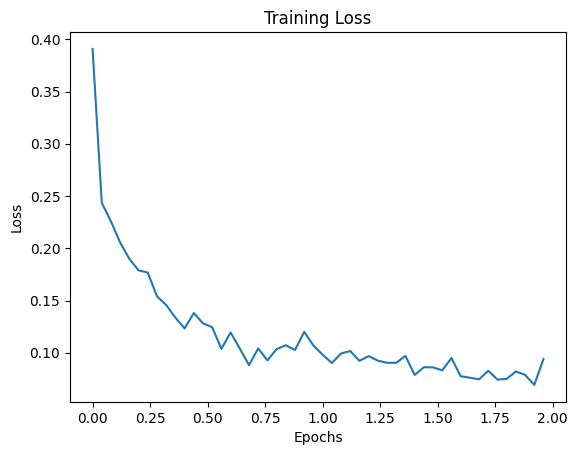

In [ ]:
import matplotlib.pyplot as plt
plt.figure()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss')

x_ = np.arange(0, len(loss_log), 1.0/len(loss_log[0]))
y_ = np.reshape(np.array(loss_log), -1)
plt.plot(x_, y_)

Store the finetuned model to the Google drive

In [ ]:
#model_path = path + 'myModels/scenic_model_github.pt'
torch.save(classifier.state_dict(), 'scenic_model_github.pt')

## Test the result

In [ ]:
from sklearn.metrics import f1_score
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

device = 'cuda:0'

# def f1_score_eval(dataloader, dataname):
#   correct = 0
#   total = 0
#   predicts = torch.zeros(0)
#   groundtruth = torch.zeros(0)
#   with torch.no_grad():
#     for testdata in dataloader:
#       encodings, labels = testdata
#       encodings = encodings.to(device)
#       for key in encodings.keys():
#         encodings[key] = torch.squeeze(encodings[key], 1)
#       output = classifier(encodings)
#       _, predicted = torch.max(output.data, 1)
#       # print(predicts)
#       # print(torch.argmax(labels.to('cpu'), 1))
#       predicts = torch.cat((predicts.to(device), predicted.to(device)), 0)
#       total+= labels.size(0)
#       groundtruth = torch.cat((groundtruth.to(device), labels.to(device)), 0)
#       correct+=(predicted.to(device)==torch.argmax(labels.to(device), 1)).sum().item()

#   print(f'Accuracy of the network on {dataname} images : {100*correct//total}%')

#   # draw confusion matrix
#   groundtruth = torch.tensor(groundtruth[:,1], dtype=torch.int)
#   predicts = torch.tensor(predicts[:], dtype=torch.int)
#   conf_mat = confusion_matrix(groundtruth.cpu().numpy(), predicts.cpu().numpy())
#   f1_score_ = f1_score(groundtruth.cpu().numpy(), predicts.cpu().numpy())
#   print(f'F1-score of the network on {dataname} images : {f1_score_}')

#   print(classification_report(groundtruth.cpu(), predicts.cpu()))
#   plt.figure(figsize=(10,7))
#   sns.heatmap(conf_mat, annot=True, cmap='Blues')
#   plt.xlabel('Predicted labels')
#   plt.ylabel('True labels')
#   plt.title(dataname)
#   plt.show()
def f1_score_eval(dataloader, dataname):
    correct = 0
    total = 0
    predicts = torch.zeros(0).to(device)
    groundtruth = torch.zeros(0).to(device)

    with torch.no_grad():
        for testdata in dataloader:
            encodings, labels = testdata
            encodings = encodings.to(device)
            labels = labels.to(device)

            for key in encodings.keys():
                encodings[key] = torch.squeeze(encodings[key], 1)

            output = classifier(encodings)
            _, predicted = torch.max(output.data, 1)

            predicts = torch.cat((predicts, predicted), 0)
            total += labels.size(0)
            groundtruth = torch.cat((groundtruth, labels), 0)
            correct += (predicted == torch.argmax(labels, 1)).sum().item()

    print(f'Accuracy of the network on {dataname} images : {100 * correct // total}%')

    # draw confusion matrix
    groundtruth = torch.tensor(groundtruth[:,1], dtype=torch.int).to(device)
    predicts = torch.tensor(predicts[:], dtype=torch.int).to(device)
    conf_mat = confusion_matrix(groundtruth.cpu().numpy(), predicts.cpu().numpy())
    f1_score_ = f1_score(groundtruth.cpu().numpy(), predicts.cpu().numpy())
    print(f'F1-score of the network on {dataname} images : {f1_score_}')

    print(classification_report(groundtruth.cpu(), predicts.cpu()))
    plt.figure(figsize=(10,7))
    sns.heatmap(conf_mat, annot=True, cmap='Blues')
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title(dataname)
    plt.show()


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Accuracy of the network on  Confusion Matrix ViLT images : 91%
F1-score of the network on  Confusion Matrix ViLT images : 0.9180990899898888
              precision    recall  f1-score   support

           0       0.92      0.92      0.92       505
           1       0.92      0.92      0.92       495

    accuracy                           0.92      1000
   macro avg       0.92      0.92      0.92      1000
weighted avg       0.92      0.92      0.92      1000



<ipython-input-19-a6753b754975>:72: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  groundtruth = torch.tensor(groundtruth[:,1], dtype=torch.int).to(device)
<ipython-input-19-a6753b754975>:73: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predicts = torch.tensor(predicts[:], dtype=torch.int).to(device)


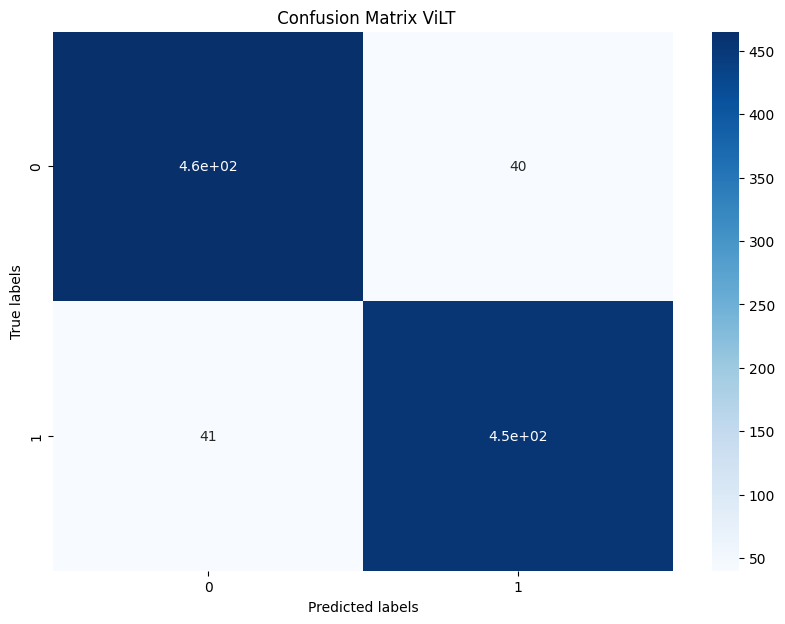

In [ ]:
#f1_score_eval(val_dataloader, 'validation')
f1_score_eval(test_dataloader, ' Confusion Matrix ViLT')

##**QUALTITAVE RESULTS**##

In [ ]:
from transformers import ViltProcessor, ViltForQuestionAnswering
import torch

processor = ViltProcessor.from_pretrained("dandelin/vilt-b32-finetuned-vqa")
model = ViltForQuestionAnswering.from_pretrained("dandelin/vilt-b32-finetuned-vqa")

class ScenicClassifier(torch.nn.Module):
  def __init__(self, enc_features: int):
    super().__init__()
    self.embedding = model.vilt
    self.classifier = torch.nn.Sequential(
        torch.nn.Linear(enc_features, 32, bias=False),
        # torch.nn.ReLU(),
        # torch.nn.Linear(64, 16, bias=False),
        torch.nn.Linear(32, 2, bias=False),
        # torch.nn.ReLU()
        )

  def forward(self, encodings):
    embeds = self.embedding(**encodings)['pooler_output']
    logits = self.classifier(embeds)

    return logits

In [ ]:
import torch
model_path = '/content/drive/MyDrive/scenic_model_github.pt'
classifier = ScenicClassifier(768)
classifier.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))
classifier.eval()

ScenicClassifier(
  (embedding): ViltModel(
    (embeddings): ViltEmbeddings(
      (text_embeddings): TextEmbeddings(
        (word_embeddings): Embedding(30522, 768)
        (position_embeddings): Embedding(40, 768)
        (token_type_embeddings): Embedding(2, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (patch_embeddings): ViltPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(32, 32), stride=(32, 32))
      )
      (token_type_embeddings): Embedding(2, 768)
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViltEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViltLayer(
          (attention): ViltAttention(
            (attention): ViltSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, 

In [ ]:
!pip install gdown
import gdown
#https://drive.google.com/file/d/1sJ5NqbCtngTlQHHsH4d_iyrMMEdOugTA/view?usp=drive_link
url = 'https://drive.google.com/uc?id=1-39gatpZL3__lLx3CY90jJFqLxPQ3w8q'
output = 'selected_cases.csv'
gdown.download(url, output, quiet=False)


Downloading...
From: https://drive.google.com/uc?id=1-39gatpZL3__lLx3CY90jJFqLxPQ3w8q
To: /content/selected_cases.csv
100%|██████████| 2.97k/2.97k [00:00<00:00, 4.61MB/s]


'selected_cases.csv'

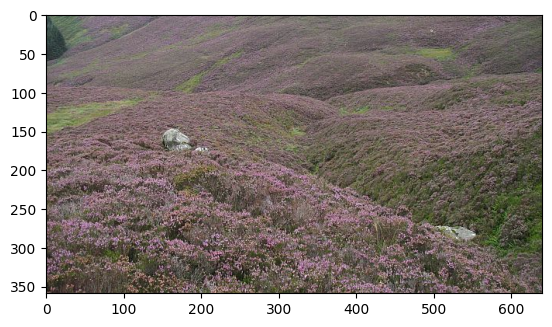

Comment: gully waist deep heather feed black burn scottish side knox knowe distinctly evil foot english side tough enough isolated outcrop boulder fell sandstone add fun


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Predicted Scenicness: 1
Actual Scenicness: 1
The model accurately predicted the scenicness.


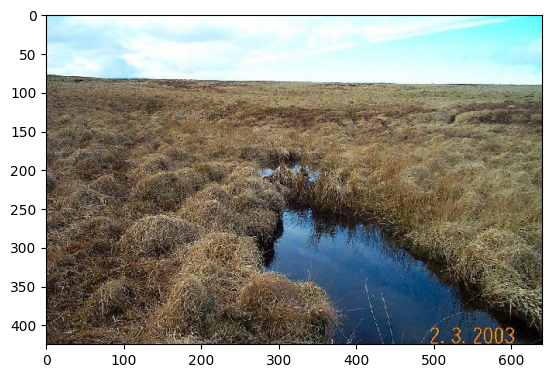

Comment: west dart head isolated place within grassy wilderness inner dartmor probably often visited tranquil seems far away rest devon sunny day ideal place spend time rain mist would atmosphere
Error during model prediction: 0
Actual Scenicness: 1
The model accurately predicted the scenicness.


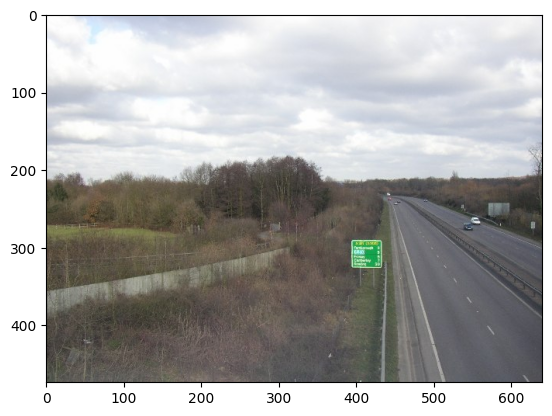

Comment: could road like yorkshire valley clogged buildings whereas blackwater valley wa relatively clear road ha built cutting embankment fence side lake wood valley still enjoyed photo wa taken looking northward footbridge accessed shawfield lane
Error during model prediction: 0
Actual Scenicness: 0
The model's prediction deviated from the actual scenicness.


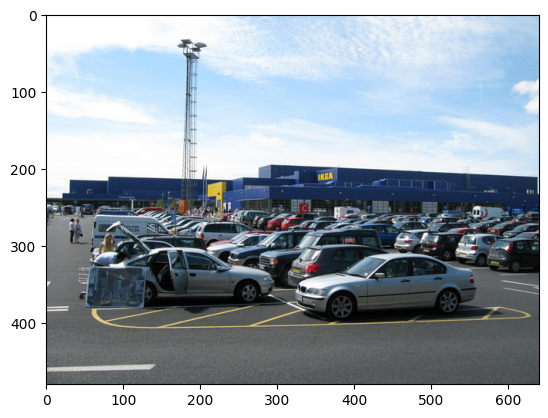

Comment: located next m62 huge ikea store gemini retail park \nthe warington store cover area 270 sq mts wa first ikea open united kingdom 1987 \ntoday 15 store dotted around united kingdom
Error during model prediction: 0
Actual Scenicness: 0
The model's prediction deviated from the actual scenicness.


In [ ]:
# ... [rest of the code]

# 2. Displaying the Images and Descriptions

import matplotlib.pyplot as plt
#selected_df_read = pd.read_csv('selected_cases.csv')

#selected_df_read = pd.read_csv('/content/drive/MyDrive/selected_cases.csv')
# Assuming you've already imported necessary libraries and set up other parts of the code
#selected_df_read = selected_df_read.reset_index(drop=True)


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")



selected_df_read = pd.read_csv('selected_cases.csv')


for index, row in selected_df_read.iterrows():
    img_path = os.path.join('/content/drive/MyDrive', row['filename'])
    img = plt.imread(img_path)
    plt.imshow(img)
    plt.show()
    print(f"Comment: {row['clean_comments']}")

    # 3. Model Predictions
    try:
        test_data = ViltDataset(pd.DataFrame([row]))
        dataloader = DataLoader(test_data, batch_size=1)
        for data in dataloader:
            encodings, labels = data
            for key in encodings.keys():
                encodings[key] = torch.squeeze(encodings[key], 1)
            outputs = classifier(encodings)
            predicted = torch.argmax(outputs, 1)
            print(f"Predicted Scenicness: {predicted.item()}")
    except Exception as e:
        print(f"Error during model prediction: {e}")

    # 4. Discussion
    try:
        print(f"Actual Scenicness: {row['scenic']}")
        if predicted.item() == row['scenic']:
            print("The model accurately predicted the scenicness.")
        else:
            print("The model's prediction deviated from the actual scenicness.")
    except Exception as e:
        print(f"Error during discussion: {e}")




In [ ]:
# can be used to reduce the GPU allocation memory
torch.cuda.empty_cache()
!nvidia-smi -caa
!nvidia-smi

Cleared Accounted PIDs for GPU 00000000:00:04.0.
All done.
Thu Sep  7 15:38:26 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   74C    P0    32W /  70W |   2265MiB / 15360MiB |     40%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                             